In [1]:
import os
import numpy as np
import scipy.io
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
warnings.filterwarnings("ignore")

In [2]:
os.chdir("C:/Users/48786/Documents/GitHub/gaze-following/data/Monkey J")
all_perf = pd.read_csv("all_perf.csv")

In [3]:
all_perf = all_perf[(all_perf['response_from_tracking'] == 2) | (all_perf['response_from_tracking'] == 6)]
all_perf = all_perf.reset_index(drop=True)

In [4]:
def logifunc(x,A,x0,k,off):
    return A / (1 + np.exp(-k*(x-x0)))+off

In [5]:
all_perf

,date,run,trial_id,cue_id,lum_change_id,lum_level,eye_position,undecided_fixation,undecided_target,soa,miss,hit,got_reward,saccade_time_to_lum,saccade_time_to_cue,response_from_tracking,initial_response_direction,cue_amplitude,filename,no_eye_data
0,2023-10-18,1,2,NaN,2,100.0,True,0.0,1.0,0.75,0,1,1,314.0,1127.5,2.0,2.0,normal,Joris_performanceEval_LED26_2023-10-18-17-16-2...,False
1,2023-10-18,1,3,NaN,6,400.0,True,0.0,1.0,0.29,0,1,1,222.0,579.0,6.0,6.0,normal,Joris_performanceEval_LED26_2023-10-18-17-16-2...,False
2,2023-10-18,1,4,NaN,2,100.0,True,0.0,1.0,1.00,0,1,1,372.5,1443.5,2.0,2.0,normal,Joris_performanceEval_LED26_2023-10-18-17-16-2...,False
3,2023-10-18,1,5,NaN,2,250.0,True,0.0,1.0,0.96,0,1,0,549.5,1580.5,2.0,2.0,normal,Joris_performanceEval_LED26_2023-10-18-17-16-2...,False
4,2023-10-18,1,6,NaN,2,100.0,True,0.0,1.0,0.84,0,1,1,290.5,1200.5,2.0,2.0,normal,Joris_performanceEval_LED26_2023-10-18-17-16-2...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15693,2023-11-20,171,88,NaN,6,19.0,True,0.0,0.0,0.03,0,1,1,362.0,462.0,6.0,6.0,normal,Joris_performanceEval_LED26_2023-11-20-17-27-2...,False
15694,2023-11-20,171,89,NaN,6,19.0,True,0.0,0.0,0.03,1,0,0,941.0,1041.0,2.0,2.0,normal,Joris_performanceEval_LED26_2023-11-20-17-27-2...,False
15695,2023-11-20,171,90,NaN,2,19.0,True,0.0,0.0,0.03,1,0,0,931.5,1031.5,6.0,6.0,normal,Joris_performanceEval_LED26_2023-11-20-17-27-2...,False
15696,2023-11-20,171,91,NaN,2,19.0,True,0.0,1.0,0.03,0,1,1,602.5,702.5,2.0,2.0,normal,Joris_performanceEval_LED26_2023-11-20-17-27-2...,False


### Determine indices for each day

In [6]:
first_filename = all_perf['filename'][0][:38]
indices = []
idx_start = 0

for i in range(len(all_perf)+1):
    if i+1 < len(all_perf):
        if all_perf['filename'][i+1].startswith(first_filename):
            continue
        else:
            first_filename = all_perf['filename'][i+1][:38]
            idx_end = i + 1
            indices.append([idx_start, idx_end])
            idx_start = i + 1
    else:
        idx_end = i + 1
        indices.append([idx_start, idx_end])
        break

### Calculate performance per session (a day)

In [9]:
perf_per_session = []

for i in np.unique(all_perf['date']):
    perf_day = all_perf[all_perf['date']==i]
    print(i, '\n')
    for i in range(len(all_perf)):

        lum_levels = np.unique(perf_day['lum_level'])

        ## Filter trial list according to lum change
        perf_levels = []
        num_samples = []

        for i in lum_levels:
            # take subset of the data for a given luminance level
            trial_lst_level = perf_day[perf_day["lum_level"]==i]
            
            hits = trial_lst_level[((trial_lst_level['got_reward']==1) | (trial_lst_level['lum_change_id']==trial_lst_level['response_from_tracking'])) & (trial_lst_level['undecided_fixation']==0)]
            fa = trial_lst_level[((trial_lst_level['got_reward']==0) | (trial_lst_level['lum_change_id']!=trial_lst_level['response_from_tracking'])) & (trial_lst_level['undecided_fixation']==0)]

            n = len(hits) + len(fa) 
            num_samples.append(n)
            if n > 0:
                performance = len(hits) / n
            else:
                performance = 0
            perf_levels.append(performance)

    final_df = pd.DataFrame({'luminance_change': lum_levels, 'performance': perf_levels, 'n_samples':num_samples})
    print(final_df, '\n')
    perf_per_session.append(final_df)

2023-10-18 

   luminance_change  performance  n_samples
0             100.0     0.921053        114
1             250.0     0.961905        105
2             400.0     0.960317        126 

2023-10-19 

   luminance_change  performance  n_samples
0              30.0     0.776190        210
1              50.0     0.884615        234
2             200.0     0.958140        215 

2023-10-23 

   luminance_change  performance  n_samples
0              15.0     0.475000         40
1             100.0     0.948718        117
2             250.0     0.975000         40
3             350.0     0.984615         65
4             400.0     0.960000         50 

2023-10-24 

   luminance_change  performance  n_samples
0              15.0     0.511905        168
1              25.0     0.735714        140
2              30.0     0.729730        111
3             250.0     0.882353        136
4             350.0     0.875000        128 

2023-10-26 

   luminance_change  performance  n_samples
0  

In [10]:
len(perf_per_session)

17

In [13]:
## make df per day

all_lums = np.unique(all_perf['lum_level'].tolist()).tolist()
zeros_init = np.zeros(len(all_lums)).tolist()
df_per_day = pd.DataFrame({'lum_level': all_lums, 'day1': zeros_init, 'day1_n': zeros_init, 'day2': zeros_init, 'day2_n': zeros_init, 
                           'day3': zeros_init, 'day3_n': zeros_init, 'day4': zeros_init,  'day4_n': zeros_init, 'day5': zeros_init, 
                           'day5_n': zeros_init, 'day6': zeros_init, 'day6_n': zeros_init, 'day7': zeros_init, 'day7_n': zeros_init,
                           'day8': zeros_init, 'day8_n': zeros_init, 'day9': zeros_init, 'day9_n': zeros_init,
                           'day10': zeros_init, 'day10_n': zeros_init, 'day11': zeros_init, 'day11_n': zeros_init,
                           'day12': zeros_init, 'day12_n': zeros_init, 'day13': zeros_init, 'day13_n': zeros_init,
                           'day14': zeros_init, 'day14_n': zeros_init, 'day15': zeros_init, 'day15_n': zeros_init,
                           'day16': zeros_init, 'day16_n': zeros_init, 'day17': zeros_init, 'day17_n': zeros_init,})

add_day = 1
add_samples = 2

for i in range(len(perf_per_session)):
    lums_lst = np.unique(perf_per_session[i]['luminance_change']).tolist()
    day_df = df_per_day[df_per_day.columns[i+add_day]]
    n_df = df_per_day[df_per_day.columns[i+add_samples]]
    add_day += 1
    add_samples += 1
    perf_subset = perf_per_session[i]
    for j in lums_lst:
        #print('Luminance level', j, '\n')
        get_df_for_lum = df_per_day[df_per_day['lum_level'] ==j]
        #print('Index in the dataframe', get_df_for_lum.index[0], '\n')
        day_df[get_df_for_lum.index[0]] = perf_subset[perf_subset['luminance_change'] == j]['performance']
        n_df[get_df_for_lum.index[0]] = perf_subset[perf_subset['luminance_change'] == j]['n_samples']
        #print('Performance', perf_subset[perf_subset['luminance_change'] == j]['performance'], '\n')


In [14]:
df_per_day.replace(0, np.nan, inplace = True)
df_per_day

,lum_level,day1,day1_n,day2,day2_n,day3,day3_n,day4,day4_n,day5,...,day13,day13_n,day14,day14_n,day15,day15_n,day16,day16_n,day17,day17_n
0,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.435065,154.0,0.496599,147.0
4,15.0,NaN,NaN,NaN,NaN,0.475000,40.0,0.511905,168.0,0.660428,...,NaN,NaN,NaN,NaN,NaN,NaN,0.582222,450.0,NaN,NaN
5,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.677419,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.631206,141.0,0.654762,168.0,0.629060,585.0,NaN,NaN,NaN,NaN
7,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.571116,457.0
8,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.689103,312.0,0.773399,203.0,0.706667,375.0,NaN,NaN,NaN,NaN
9,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.813953,86.0,NaN,NaN


### Calculate overall performance 

In [15]:
lum_levels = np.unique(df_per_day['lum_level'])
perf_levels = []
num_samples = []

df_per_day_perf = df_per_day.loc[:, ['lum_level', 'day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'day10', 'day11','day12','day13','day14','day15','day16','day17']]
df_per_day_samples = df_per_day.loc[:, ['lum_level', 'day1_n', 'day2_n', 'day3_n', 'day4_n', 'day5_n', 'day6_n', 'day7_n', 'day8_n', 'day9_n','day10_n', 'day11_n','day12_n','day13_n','day14_n','day15_n','day16_n','day17_n']]

for i in lum_levels:
    subset_perf = df_per_day_perf[df_per_day_perf['lum_level'] == i]
    subset_samples = df_per_day_samples[df_per_day_samples['lum_level'] == i]
    mean_perf = np.nanmean(subset_perf[subset_perf.columns[1:]].values)
    perf_levels.append(mean_perf)
    samples_sum = np.nansum(subset_samples[subset_samples.columns[1:]].values)
    num_samples.append(samples_sum)

final_df = pd.DataFrame({'luminance_change': lum_levels, 'performance': perf_levels, 'n_samples':num_samples})
final_df

,luminance_change,performance,n_samples
0,0.2,0.450207,482.0
1,1.0,0.460858,461.0
2,5.0,0.539366,442.0
3,10.0,0.459779,473.0
4,15.0,0.592208,1945.0
5,17.0,0.661626,158.0
6,18.0,0.621993,1271.0
7,19.0,0.571116,457.0
8,20.0,0.792292,898.0
9,22.0,0.813953,86.0


## Logistic fit

In [16]:
box_df= pd.DataFrame({'15':df_per_day[df_per_day['lum_level']==15].values.tolist()[0],
                     '18':df_per_day[df_per_day['lum_level']==18].values.tolist()[0],
                     '20':df_per_day[df_per_day['lum_level']==20].values.tolist()[0],
                     '25':df_per_day[df_per_day['lum_level']==25].values.tolist()[0],
                     '30':df_per_day[df_per_day['lum_level']==30].values.tolist()[0],
                     '50':df_per_day[df_per_day['lum_level']==50].values.tolist()[0],
                     '100':df_per_day[df_per_day['lum_level']==100].values.tolist()[0],
                     '200':df_per_day[df_per_day['lum_level']==200].values.tolist()[0],
                     '250':df_per_day[df_per_day['lum_level']==250].values.tolist()[0],
                     '350':df_per_day[df_per_day['lum_level']==350].values.tolist()[0],
                     '400':df_per_day[df_per_day['lum_level']==400].values.tolist()[0]})
#box_df

In [17]:
logistic_params, covariance = curve_fit(logifunc, final_df['luminance_change'].tolist(), final_df['performance'].tolist(), maxfev=2000, p0=[50,185,0.1,-222])
y_fit = logifunc(final_df['luminance_change'].tolist(), *logistic_params)

In [18]:
covariance

array([[ 2.77993661e-03, -4.61516004e-02, -2.24029952e-03,
        -2.25251479e-03],
       [-4.61516004e-02,  2.59049291e+00,  3.85545553e-02,
         5.43429803e-02],
       [-2.24029952e-03,  3.85545553e-02,  3.59071510e-03,
         1.93173128e-03],
       [-2.25251479e-03,  5.43429803e-02,  1.93173128e-03,
         2.14273586e-03]])

In [22]:
ticks = [1, 10, 20, 30, 50, 100, 150, 200, 250, 350, 400]

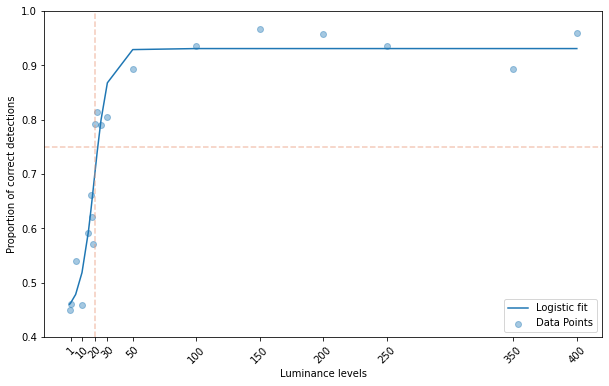

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(final_df['luminance_change'].tolist(), final_df['performance'].tolist(), label = 'Data Points', alpha=0.4)
ax.plot(final_df['luminance_change'].tolist(), y_fit, '-', label = 'Logistic fit')
#box_df_2.boxplot(ax=ax, positions=box_df.columns.astype(int).tolist(), widths = 10)
plt.axhline(y=0.75, alpha=0.5, color='#E99675', linestyle = '--')
plt.axvline(x=20, alpha=0.5, color='#E99675', linestyle = '--')
plt.xlabel('Luminance levels')
plt.ylabel('Proportion of correct detections')
plt.xticks(ticks, rotation=45)
plt.ylim([0.4,1])
plt.legend()
plt.show()
fig.tight_layout()